# Modelling

In [1]:
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SelectKBest, f_regression



### Baseline Model - Linear Regression

The baseline model will be a linear regression model that considers a selection of engineered features. These will consist of the rolling variance and mean, and lag taken at various time intervals. This model will predict the next interval along for each of the hourly, daily, and weekly granularities.

<center>

|Granularity|Window Sizes|
|-----------|------------|
|Hourly     |6h, 12h, 24h|
|Daily      |7d, 14d, 30d|
|Weekly     |2w, 4w, 8w  |


<center>


In [2]:
# Load DataFrames
LCL_hrs = pd.read_pickle('data/LCL_unstack_hrs.pkl')
LCL_day = pd.read_pickle('data/LCL_unstack_day.pkl')
LCL_wks = pd.read_pickle('data/LCL_unstack_wks.pkl')

In [3]:
# Find rolling variances and means, and lags for each tariff

DF_names = []
DF_list = []

# Define windows for each DataFrame
DF_dict = {
   'DF':[LCL_hrs, LCL_day, LCL_wks],                    # List the DataFrames
   'period':['_hrs','_day','_wks'],                     # Periods used to name output DataFrames
   'letter':['h_', 'd_', 'w_'],                         # Suffixes used to name columns in output DataFrames
   'n_ints':[[6, 12, 24], [7, 14, 30], [2, 4, 8]],      # Specify number of points to include in window/points to lag
}

for i in range(len(DF_dict['DF'])):        # Loop through index
    DF = DF_dict['DF'][i]                  # Select DataFrame
    p_suf = DF_dict['period'][i]           # Select suffixes for naming
    l_suf = DF_dict['letter'][i]
    n_ints = DF_dict['n_ints'][i]          # Select list of windows

    for col in DF.columns:                                              # Loop through Std and Tou columns
        df = (pd.DataFrame(DF[col])).rename(columns = {col:'KW'})       # New DataFrame for each column

        for j in n_ints:                                                # Loop through windows
            df[str(j)+l_suf+'var'] = df['KW'].rolling(j).var().shift()  # Calculate rolling variance
            df[str(j)+l_suf+'avg'] = df['KW'].rolling(j).mean().shift() # Calculate rolling mean
            df[str(j)+l_suf+'lag'] = df['KW'].shift(periods = j)        # Find lag

        df.dropna(inplace = True)                              # Drop nulls due to rolling window
        globals()[col + p_suf + '_df'] = df.copy()             # Name output DataFrame
        DF_list.append(globals()[col + p_suf + '_df'])         # Keep track of DataFrames for corellation plots
        DF_names.append(col + p_suf + '_df')                   # Keep track of DataFrame names for corellation plots

In [23]:
pd.to_pickle(DF_dict, 'data/DF_dict.pkl')

In [4]:
Std_wks_df

,KW,2w_var,2w_avg,2w_lag,4w_var,4w_avg,4w_lag,8w_var,8w_avg,8w_lag
DateTime,,,,,,,,,,
2012-02-26,0.528453,0.001891,0.597541,0.628293,0.001436,0.592809,0.553962,0.001562,0.564902,0.523669
2012-03-04,0.513584,0.000735,0.547621,0.566788,0.002260,0.586432,0.622192,0.001508,0.565500,0.540989
2012-03-11,0.530022,0.000111,0.521018,0.528453,0.002619,0.559280,0.628293,0.001794,0.562074,0.532780
2012-03-18,0.485568,0.000135,0.521803,0.513584,0.000512,0.534712,0.566788,0.001818,0.561730,0.550542
2012-03-25,0.448626,0.000988,0.507795,0.530022,0.000425,0.514407,0.528453,0.002554,0.553608,0.553962
...,...,...,...,...,...,...,...,...,...,...
2014-02-02,0.504806,0.000041,0.493757,0.489244,0.000098,0.498779,0.512540,0.000068,0.500520,0.501627
2014-02-09,0.490609,0.000021,0.501538,0.498271,0.000042,0.496845,0.495061,0.000070,0.500918,0.499615
2014-02-16,0.493738,0.000101,0.497707,0.504806,0.000052,0.495732,0.489244,0.000084,0.499792,0.495391


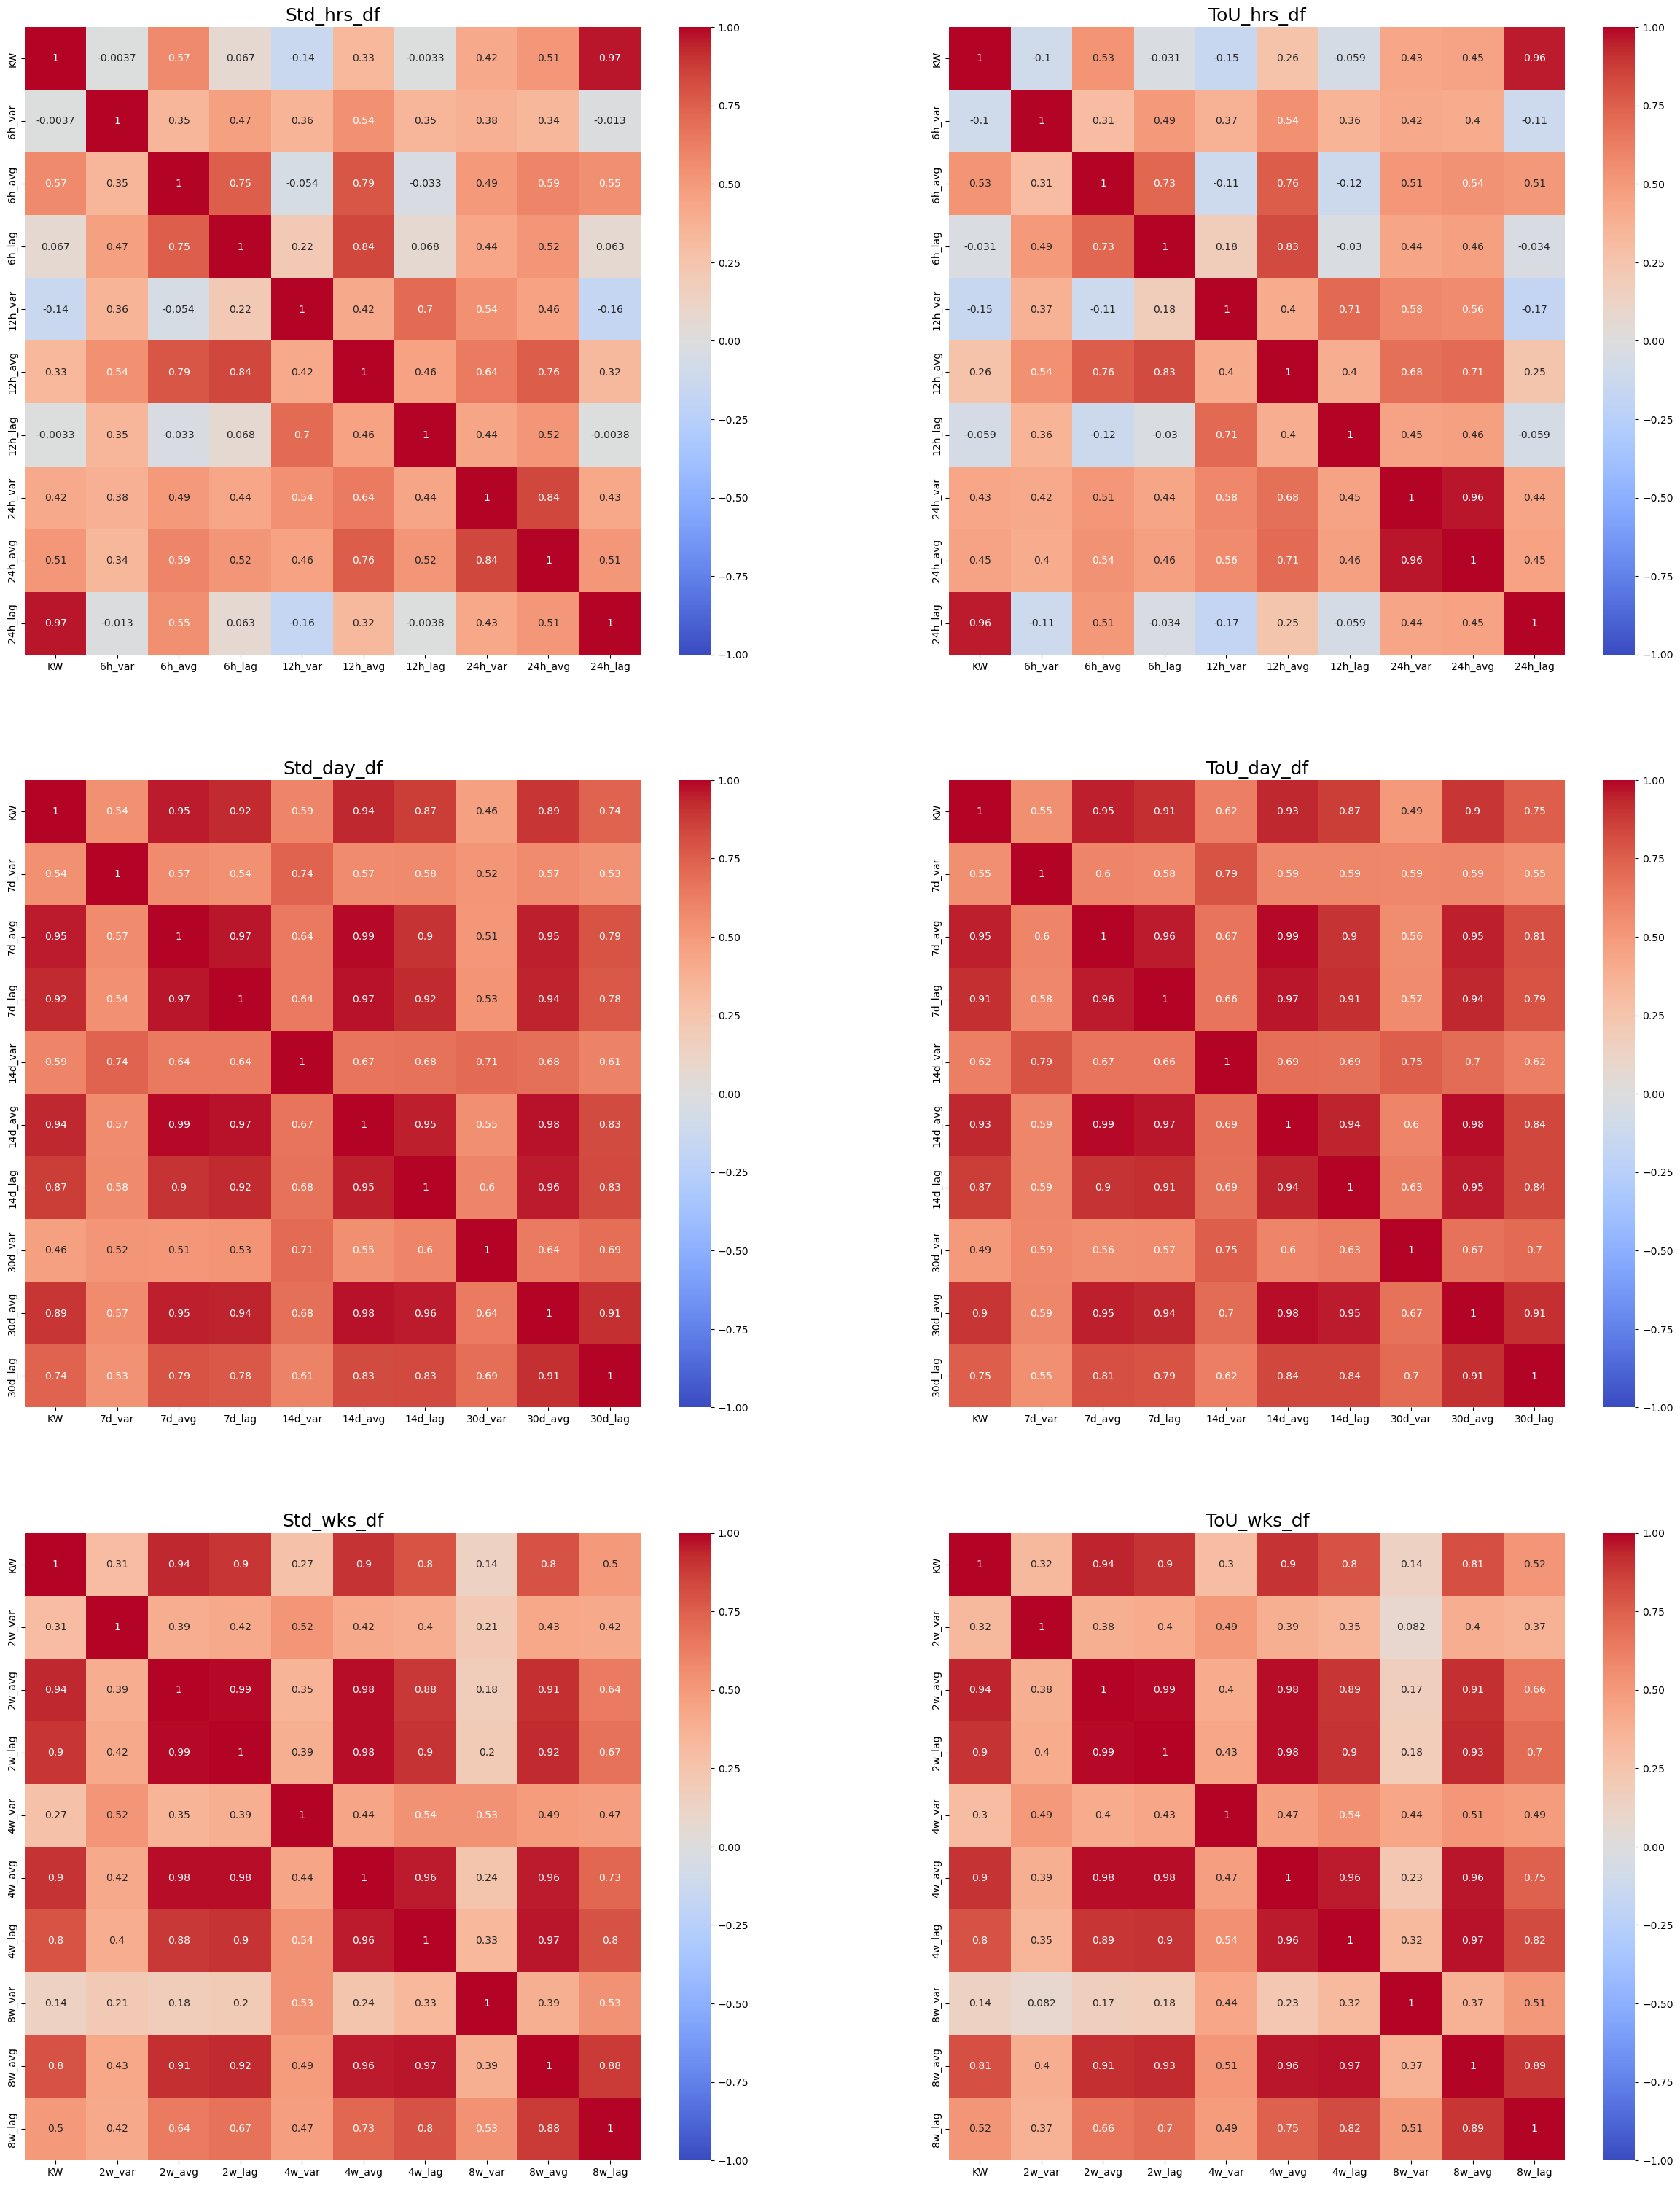

In [5]:
plt.subplots(3,2, figsize = (30,38))
count = 1

for i in range(len(DF_list)):
    df = DF_list[i]
    name = DF_names[i]
    plt.subplot(3,2,count)
    sns.heatmap(df.corr(), annot = True, vmin = -1, vmax = 1, cmap = 'coolwarm')
    plt.title(name, fontsize = 18)
    count +=1


plt.show()

In [6]:
def do_linear (df):
    y = df['KW']
    X = df.drop(columns = 'KW')
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 8)

    estimators = [
        ('scale', StandardScaler()),
        ('reduce', PCA()),
        ('model', LinearRegression())
        ]

    pipe = Pipeline(estimators)

    params = [
        {'scale':[StandardScaler(), None],
        'reduce':[PCA()],
        'reduce__n_components':[3, 4, 5, 6, 7, 8],
        'model':[LinearRegression()]},

        {'scale':[StandardScaler(), None],
        'reduce':[PCA()],
        'reduce__n_components':[3, 4, 5, 6, 7, 8],
        'model':[Lasso(random_state=8), Ridge(random_state=8)],
        'model__alpha':[10**x for x in range(-2,3)]},

         {'scale':[StandardScaler(), None],
        'reduce':[SelectKBest(score_func=f_regression, k=1), None],
        'model':[LinearRegression()]},

         {'scale':[StandardScaler(),None],
        'reduce':[SelectKBest(score_func=f_regression, k=1), None],
        'model':[Lasso(random_state=8), Ridge(random_state=8)],
        'model__alpha':[10**x for x in range(-2,3)],}

    ]

    grid_cv = GridSearchCV(pipe, params, cv=5, verbose=1)
    grid_fit = grid_cv.fit(X_train, y_train)
    test_acc = grid_fit.best_estimator_.fit(X_train, y_train).score(X_test, y_test)

    print(f"===========================================================================================================\
            \nBest model found with grid search:\
            \n{grid_fit.best_params_}\
            \n-----------------------------------------------------------------------------------------------------------\
            \nCross validation accuracy score:\
            \n{max(grid_fit.cv_results_['mean_test_score'])}\
            \n\nTest accuracy score:\
            \n{test_acc}\
            \n===========================================================================================================\n\n\n")
    
    

In [7]:
Std_wks_df

,KW,2w_var,2w_avg,2w_lag,4w_var,4w_avg,4w_lag,8w_var,8w_avg,8w_lag
DateTime,,,,,,,,,,
2012-02-26,0.528453,0.001891,0.597541,0.628293,0.001436,0.592809,0.553962,0.001562,0.564902,0.523669
2012-03-04,0.513584,0.000735,0.547621,0.566788,0.002260,0.586432,0.622192,0.001508,0.565500,0.540989
2012-03-11,0.530022,0.000111,0.521018,0.528453,0.002619,0.559280,0.628293,0.001794,0.562074,0.532780
2012-03-18,0.485568,0.000135,0.521803,0.513584,0.000512,0.534712,0.566788,0.001818,0.561730,0.550542
2012-03-25,0.448626,0.000988,0.507795,0.530022,0.000425,0.514407,0.528453,0.002554,0.553608,0.553962
...,...,...,...,...,...,...,...,...,...,...
2014-02-02,0.504806,0.000041,0.493757,0.489244,0.000098,0.498779,0.512540,0.000068,0.500520,0.501627
2014-02-09,0.490609,0.000021,0.501538,0.498271,0.000042,0.496845,0.495061,0.000070,0.500918,0.499615
2014-02-16,0.493738,0.000101,0.497707,0.504806,0.000052,0.495732,0.489244,0.000084,0.499792,0.495391


In [8]:
for i in range(len(DF_list)):
    df = DF_list[i]
    df_name = DF_names[i]
    print(f"===================================== OPTIMISING MODEL FOR {df_name} =====================================")
    do_linear(df)

===================================== OPTIMISING MODEL FOR Std_hrs_df =====================================
Fitting 5 folds for each of 176 candidates, totalling 880 fits
Best model found with grid search:            
{'model': Ridge(alpha=1, random_state=8), 'model__alpha': 1, 'reduce': None, 'scale': StandardScaler()}            
-----------------------------------------------------------------------------------------------------------            
Cross validation accuracy score:            
0.9446979141417483            

Test accuracy score:            
0.9464726767557665            



===================================== OPTIMISING MODEL FOR ToU_hrs_df =====================================
Fitting 5 folds for each of 176 candidates, totalling 880 fits
Best model found with grid search:            
{'model': Ridge(alpha=1, random_state=8), 'model__alpha': 1, 'reduce': None, 'scale': StandardScaler()}            
--------------------------------------------------------------------